In [23]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np

In [24]:
vol_img = sitk.ReadImage(r"C:\Users\Audit\Uppsala - Masters Europe\Semester 3\Project in Image analysis - Software\UCAN-PET-CT-image-data-handling-pipeline\Task 2.1\Data\sample3Dimg.nrrd")

file_reader = sitk.ImageFileReader()
file_reader.SetImageIO('NrrdImageIO')
file_reader.SetFileName(r"C:\Users\Audit\Uppsala - Masters Europe\Semester 3\Project in Image analysis - Software\UCAN-PET-CT-image-data-handling-pipeline\Task 2.1\Data\sample3Dimg.nrrd")
file_reader.Execute()

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x0000021FAEB77900> >

(-0.5, 167.5, 167.5, -0.5)

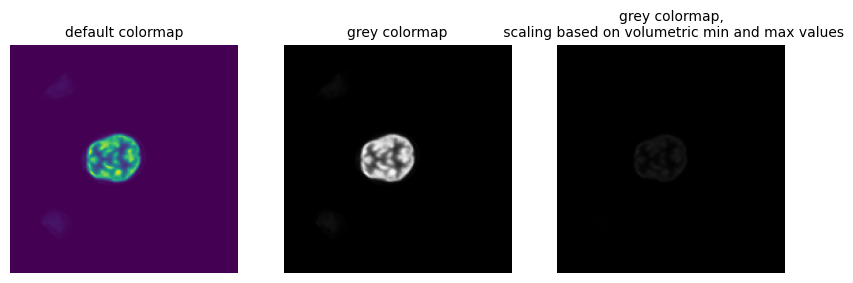

In [25]:
# Display the image slice from the middle of the stack, z axis
# print(vol_img.GetDepth())
z = int(vol_img.GetDepth()/10)
npa_zslice = sitk.GetArrayViewFromImage(vol_img)[z,:,:]
npa = sitk.GetArrayViewFromImage(vol_img)
# Three plots displaying the same data, how do we deal with the high dynamic range?
fig = plt.figure(figsize=(10,3))

fig.add_subplot(1,3,1)
plt.imshow(npa_zslice)
plt.title('default colormap', fontsize=10)
plt.axis('off')

fig.add_subplot(1,3,2)
plt.imshow(npa_zslice,cmap=plt.cm.Greys_r)
plt.title('grey colormap', fontsize=10)
plt.axis('off')

fig.add_subplot(1,3,3)
plt.title('grey colormap,\n scaling based on volumetric min and max values', fontsize=10)
plt.imshow(npa_zslice,cmap=plt.cm.Greys_r, vmin=npa.min(), vmax=npa.max())
plt.axis('off')

In [10]:
#stik [x,y,z]-> numpy [z,x,y]
nda = sitk.GetArrayFromImage(vol_img)
print(vol_img.GetSize())
print(nda.shape)

nda2d=sitk.GetArrayFromImage(vol_img[:,:,0])
print(nda2d)

(168, 168, 553)
(553, 168, 168)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [11]:
# numpy array  -> stik

nda_as_image = sitk.GetImageFromArray(nda)
print(nda_as_image.GetSize())

(168, 168, 553)


In [12]:
# voxel queries

print(vol_img.GetPixelIDValue())
print(vol_img.GetPixelIDTypeAsString())
print(vol_img.GetNumberOfComponentsPerPixel())

9
64-bit float
1


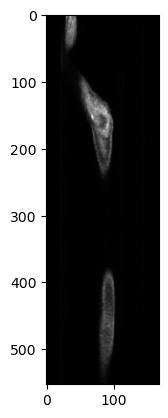

In [13]:
# Accessing and slicing
#help(vol_img.GetPixel)

#slice voxel first

# row z wise slice
# slice_2d=vol_img[:,:,50]
# plt.imshow(sitk.GetArrayFromImage(slice_2d),cmap='gray')

# row x wise slice
# slice_2d=vol_img[96,:,:]
# print(type(slice_2d))
# plt.imshow(np.add(sitk.GetArrayFromImage(slice_2d)),cmap='gray')

# row y wise slice
slice_2d=vol_img[:,40,:]
plt.imshow(sitk.GetArrayFromImage(slice_2d),cmap='gray')


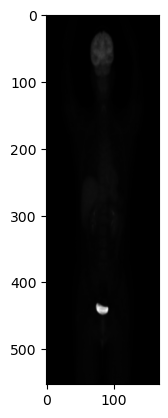

In [22]:
#display img averaged over all pixels

mean_img=np.zeros(nda_as_image.GetSize()[0:1])
for i in range (nda_as_image.GetSize()[0]):
   mean_img=mean_img+sitk.GetArrayFromImage(vol_img[i,:,:])
mean_img=mean_img/nda_as_image.GetSize()[0]
#mean_img=mean_img+50*np.ones(nda_as_image.GetSize()[0:1])
plt.imshow(mean_img,cmap='gray')

In [ ]:
#slice angle
plt.imshow(npa_zslice,cmap=plt.cm.Greys_r, vmin=npa.min(), vmax=npa.max())

#type of projecttion - min/max

In [101]:
projection = {'sum': sitk.SumProjection,
              'mean':  sitk.MeanProjection,
              'std': sitk.StandardDeviationProjection,
              'min': sitk.MinimumProjection,
              'max': sitk.MaximumProjection}
ptype = 'max'
paxis = 0

rotation_axis = [0,0,1]
rotation_angles = np.linspace(-1/2*np.pi, 1/2*np.pi, int(180.0/15.0)) #15 degree 
rotation_center = vol_img.TransformContinuousIndexToPhysicalPoint([(index-1)/2.0 for index in vol_img.GetSize()])
rotation_transform = sitk.VersorRigid3DTransform()
rotation_transform.SetCenter(rotation_center)


#Compute bounding box of rotating volume and the resampling grid structure

image_indexes = list(zip([0,0,0], [sz-1 for sz in vol_img.GetSize()]))
image_bounds = []
for i in image_indexes[0]:
    for j in image_indexes[1]:
        for k in image_indexes[2]:
            image_bounds.append(vol_img.TransformIndexToPhysicalPoint([i,j,k]))

all_points = []
for angle in rotation_angles:
    rotation_transform.SetRotation(rotation_axis, angle)    
    all_points.extend([rotation_transform.TransformPoint(pnt) for pnt in image_bounds])
all_points = np.array(all_points)
min_bounds = all_points.min(0)
max_bounds = all_points.max(0)

#resampling grid will be isotropic so no matter which direction we project to
#the images we save will always be isotropic (required for vol_img formats that 
#assume isotropy - jpg,png,tiff...)

new_spc = [np.min(vol_img.GetSpacing())]*3
new_sz = [int(sz/spc + 0.5) for spc,sz in zip(new_spc, max_bounds-min_bounds)]


proj_images = []
i=0
for angle in rotation_angles:
    rotation_transform.SetRotation(rotation_axis, angle) 
    resampled_image = sitk.Resample(image1=vol_img,
                                    size=new_sz,
                                    transform=rotation_transform,
                                    interpolator=sitk.sitkLinear,
                                    outputOrigin=min_bounds,
                                    outputSpacing=new_spc,
                                    outputDirection = [1,0,0,0,1,0,0,0,1],
                                    defaultPixelValue =  -1000, #HU unit for air in CT, possibly set to 0 in other cases
                                    outputPixelType = vol_img.GetPixelID())
    proj_image = projection[ptype](resampled_image, paxis)
    extract_size = list(proj_image.GetSize())
    extract_size[paxis]=0
    proj_images.append(sitk.Extract(proj_image, extract_size))
    print(i,angle)
    i+=1

# Stack all images into fuax-volume for display
#sitk.Show(sitk.JoinSeries(proj_images))



0 -1.5707963267948966
1 -1.2851969946503699
2 -0.9995976625058433
3 -0.7139983303613167
4 -0.42839899821678995
5 -0.14279966607226324
6 0.14279966607226324
7 0.42839899821678995
8 0.7139983303613167
9 0.9995976625058431
10 1.28519699465037
11 1.5707963267948966


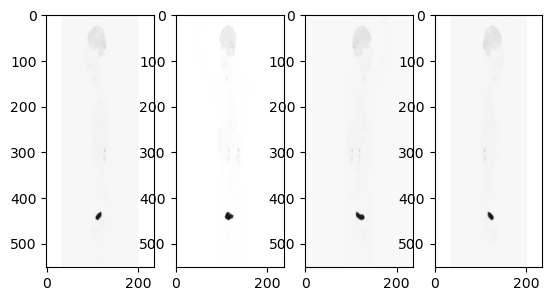

In [102]:
#proj_image[0,:,:].GetSize()
imgs=[]
for i in [0,3,9,11]:
    ext=sitk.Extract(proj_images[i], proj_images[i].GetSize())
    inv_ext=sitk.InvertIntensity(ext,maximum=255)
    imgs.append(inv_ext)
    #plt.imshow(sitk.GetImageFromArray(proj_image[0,:,:]),cmap='gray')

for i in range(1,5):
    plt.subplot(1,4,i)
    plt.imshow(sitk.GetArrayFromImage(imgs[i-1]),cmap='gray')